In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import resample

from seiz_eeg.dataset import EEGDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from data.dataset import EEGDatasetWrapper

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import wandb
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class EEGGraphFeatureDataset(torch.utils.data.Dataset):
    def __init__(self, eeg_dataset, window_size=100):
        self.eeg_dataset = eeg_dataset
        self.window_size = window_size

    def __len__(self):
        return len(self.eeg_dataset)

    def __getitem__(self, idx):
        signal, label = self.eeg_dataset[idx]  # signal shape: (seq_len, num_electrodes)
        features = self.extract_graph_features(signal)  # (num_windows, num_electrodes, fft_dim)
        return features, label

    def extract_graph_features(self, signal):
        """
        Args:
            signal: numpy array of shape (seq_len, num_electrodes)
        Returns:
            Tensor of shape (num_windows, num_freqs, num_electrodes)
        """
        seq_len, num_electrodes = signal.shape
        fs = 250  # Hz
        step = int(self.window_size)
        windows = []

        for start in range(0, seq_len - self.window_size + 1, step):
            windows.append(signal[start:start+self.window_size])

        windows = np.stack(windows)  # (num_windows, window_size, num_electrodes)
        
        # FFT along time axis
        fft_windows = np.fft.fft(windows, axis=1)
        fft_windows = np.abs(fft_windows)
        fft_windows = np.log(np.maximum(fft_windows, 1e-8))  # Log power

        # Frequency selection
        freqs = np.fft.fftfreq(self.window_size, d=1/fs)
        pos_mask = (freqs >= 0.5) & (freqs <= 30)
        fft_windows = fft_windows[:, pos_mask, :]  # (num_windows, num_freqs, num_electrodes)

        return torch.from_numpy(fft_windows).float()

In [3]:
data_root = "data/data"
data_preprocessing = "raw"
eeg_data_wrapper= EEGDatasetWrapper(
    data_root,
    data_preprocessing)

In [4]:
selected_ids = eeg_data_wrapper.get_subject_ids()
validation_id = "s002" 
selected_ids.remove(validation_id)
train_dataset, val_dataset = eeg_data_wrapper.leave_one_out_split(
        validation_id, selected_ids
)
test_dataset = eeg_data_wrapper.test_dataset()

labels = train_dataset.get_label_array()
labels = np.array(labels)
# get ratio positive and negative samples
pos_ratio = np.sum(labels == 0) / np.sum(labels == 1)
print(f"Positive ratio: {pos_ratio:.2f}")

train_data_label_1 = []
train_data_label_0 = []
for i, (train_data, label) in enumerate(train_dataset):
        if label == 1:
                train_data_label_1.append((train_data, label))
        else:
                train_data_label_0.append((train_data, label))
train_data_label_1 = np.array(train_data_label_1, dtype=object)
train_data_label_0 = np.array(train_data_label_0, dtype=object)
print(f"Number of samples with label 1: {len(train_data_label_1)}")
print(f"Number of samples with label 0: {len(train_data_label_0)}")
# Resample the data to have the same number of samples
num_samples = min(len(train_data_label_1), len(train_data_label_0))
#randomly select samples from the larger class
train_data_label_0 = train_data_label_0[np.random.choice(len(train_data_label_0), num_samples, replace=False)]
train_data_label_1 = train_data_label_1[np.random.choice(len(train_data_label_1), num_samples, replace=False)]
train_dataset = np.concatenate((train_data_label_0, train_data_label_1), axis=0)
# Shuffle the dataset
np.random.shuffle(train_dataset)
# Convert to DataLoader

print(f"Number of samples in the training set: {len(train_dataset)}")
train_dataset = EEGGraphFeatureDataset(train_dataset, window_size=500)
val_dataset = EEGGraphFeatureDataset(val_dataset, window_size=500)
test_dataset = EEGGraphFeatureDataset(test_dataset, window_size=500)
test_data , label = train_dataset.__getitem__(0)

print(f"Test data shape: {test_data.shape}")
print (test_data)

Positive ratio: 4.00
Number of samples with label 1: 2096
Number of samples with label 0: 8393
Number of samples in the training set: 4192
Test data shape: torch.Size([6, 60, 19])
tensor([[[ 8.0748,  8.5077,  7.4268,  ...,  7.7004,  7.4536, 10.4550],
         [ 7.6228,  7.1374,  7.7758,  ...,  7.3501,  7.4915, 10.1839],
         [ 7.3244,  6.6025,  7.6862,  ...,  7.3292,  7.0493,  9.7574],
         ...,
         [ 3.6212,  4.2166,  3.3970,  ...,  3.4977,  4.0541,  5.5256],
         [ 3.7783,  2.2837,  4.5593,  ...,  4.5184,  4.3054,  6.5399],
         [ 4.5729,  4.2341,  4.5841,  ...,  4.2643,  4.0084,  6.3583]],

        [[ 6.8044,  6.7126,  6.8260,  ...,  7.1486,  6.8144,  9.0168],
         [ 6.0836,  6.5029,  5.4616,  ...,  6.3818,  6.4261,  8.4886],
         [ 7.1434,  6.3380,  6.3545,  ...,  5.7894,  6.2438,  8.1685],
         ...,
         [ 3.9372,  3.3957,  3.5993,  ...,  3.6169,  3.1741,  4.6498],
         [ 4.2600,  3.1510,  1.8962,  ...,  4.0902,  4.5718,  5.4053],
         

In [5]:
train_loader = DataLoader(
        train_dataset, batch_size=32, shuffle=True
    )
val_loader = DataLoader(val_dataset, batch_size=32,shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import dense_to_sparse


class Hyper_GAT_Model(nn.Module):
    def __init__(self, input_dim, gat_hidden_dim=80, output_dim=1, gat_heads=8):
        super(Hyper_GAT_Model, self).__init__()
        self.num_electrodes = 19
        self.gat_heads = gat_heads
        self.input_dim = input_dim  # num_freqs (feature per node)

        # Debug containers
        self.debug_info = {}

        # GAT 1 (per-window spatial)
        self.gat1 = GATv2Conv(in_channels=input_dim, out_channels=gat_hidden_dim, heads=gat_heads, concat=True)
        self.gat2 = GATv2Conv(in_channels=gat_hidden_dim * gat_heads, out_channels=gat_hidden_dim, heads=gat_heads, concat=True)
        # Final classifier
        self.attention_pool = nn.Linear(gat_hidden_dim * gat_heads, 1)
        self.fc = nn.Linear(gat_hidden_dim * gat_heads, output_dim)

    def build_spatiotemporal_graph(self, num_nodes, num_windows):
        total_nodes = num_nodes * num_windows
        adj = torch.zeros((total_nodes, total_nodes))

        # Step 1: Intra-window (spatial) connections
        for w in range(num_windows):
            start = w * num_nodes
            end = start + num_nodes
            adj[start:end, start:end] = 1  # fully connect within window

        # Step 2: Inter-window (temporal) connections
        for w in range(num_windows - 1):
            for n in range(num_nodes):
                src = w * num_nodes + n
                dst = (w + 1) * num_nodes + n
                adj[src, dst] = 1
                adj[dst, src] = 1  # make it bidirectional if needed


        edge_index, _ = dense_to_sparse(adj)
        return edge_index  # shape (2, num_edges)


    def forward(self, x, return_debug=False):
        """
        Args:
            x: Tensor of shape (batch_size, num_freqs, num_electrodes)
            return_debug: If True, also returns intermediate tensors for debugging
        Returns:
            logits: (batch_size,) or (logits, debug_dict)
        """
        batch_size, num_windows, num_freqs, num_electrodes = x.shape
        edge_index = self.build_spatiotemporal_graph(num_electrodes, num_windows).to(x.device)

        graph_outputs = []
        debug_info = []

        for b in range(batch_size):
            nodes = x[b].permute(0,2, 1)  # shape: (num_windows, num_electrodes, num_freqs)
            nodes = nodes.reshape(num_windows * num_electrodes, num_freqs)  # shape: (num_windows * num_electrodes, num_freqs)
            out = self.gat1(nodes, edge_index)  # shape: (num_nodes, hidden_dim)
            out = F.elu(out)  # activation function
            out = self.gat2(out, edge_index)
            attn_scores = self.attention_pool(out)  # (num_nodes, 1)
            attn_scores = torch.softmax(attn_scores, dim=0)  # (num_nodes, 1)
            pooled = (attn_scores * out).sum(dim=0)  # weighted sum
            graph_outputs.append(pooled)

        graph_outputs = torch.stack(graph_outputs, dim=0)  # (batch_size, gat_hidden_dim * gat_heads)
        logits = self.fc(graph_outputs)  # (batch_size, 1)

        return logits.squeeze(1)  # (batch_size,)


    def get_graph_embeddings(self, x):
        """
        Returns: tensor (batch_size, hidden_dim)
        """
        logits, debug = self.forward(x, return_debug=True)
        return torch.stack(debug["graph_embeddings"], dim=0)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5
model = Hyper_GAT_Model(input_dim=60).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
pos_weight = torch.tensor([pos_ratio])
loss_fn = nn.BCEWithLogitsLoss()#pos_weight=pos_weight)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / (step + 1)
        loop.set_postfix(loss=avg_loss)


Best threshold: 0.4444
Validation Loss: 0.4487
Accuracy: 0.8642
F1 Score: 0.5278
ROC AUC: 0.7909
Macro F1 Score: 0.7242


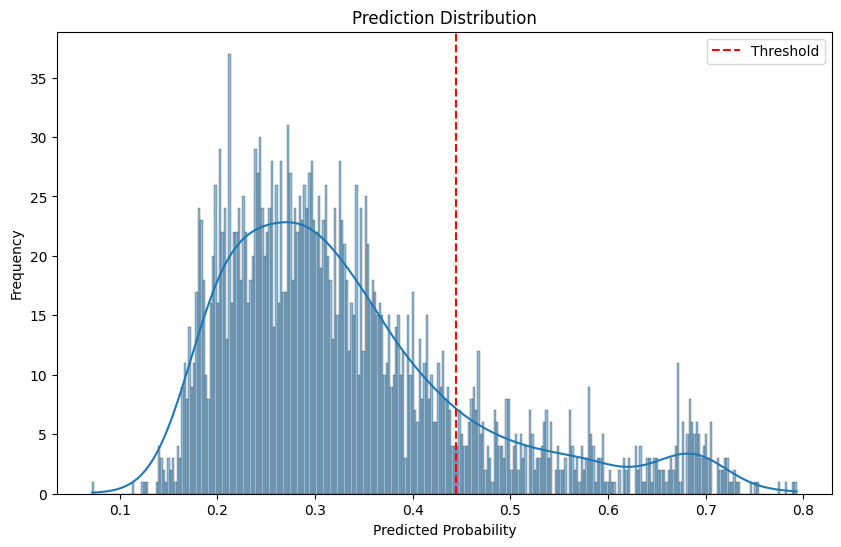

In [9]:
model.eval()
val_loss = 0.0
predictions = []
true_labels = []

with torch.no_grad():
    loop = tqdm(val_loader, desc="Validation", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        logits = model(x_batch)


        loss = loss_fn(logits, y_batch)
        val_loss += loss.item()

        preds = torch.sigmoid(logits).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(y_batch.cpu().numpy())

        loop.set_postfix(batch_loss=loss.item())

avg_val_loss = val_loss / len(loop)

# Metrics
predictions = np.array(predictions)
true_labels = np.array(true_labels)

thresholds = np.linspace(0, 1, 100)
f1s = [f1_score(true_labels, predictions > t) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]
print(f"Best threshold: {best_t:.4f}")
binary_preds = (predictions > 0.5).astype(int)

accuracy = accuracy_score(true_labels, binary_preds)
f1 = f1_score(true_labels, binary_preds)
roc_auc = roc_auc_score(true_labels, predictions)

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
# print macro f1 score
macro_f1 = f1_score(true_labels, binary_preds, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}")

#plot prediction distribution
plt.figure(figsize=(10, 6))
sns.histplot(predictions, bins=300, kde=True)
plt.axvline(x=best_t, color='r', linestyle='--', label='Threshold')
plt.title('Prediction Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [11]:
model.eval()
all_predictions = []
all_ids = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, x_ids = batch
        x_batch = x_batch.float().to(device)
        logits = model(x_batch)  # logits: (batch,) 
        preds = torch.sigmoid(logits).cpu().numpy()
        preds = (preds > 0.5).astype(int)
        all_predictions.extend(preds)
        all_ids.extend(x_ids)  # Store sample ID
all_ids = [str(i).replace("__", "$$") for i in all_ids]
all_ids = [i.replace("_", "") for i in all_ids]
all_ids = [i.replace("$$", "_") for i in all_ids]
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})
submission_df.to_csv("submission_HyperGAT.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
